# Trabajo práctico N°2
## Detectando lugares del mundo.

Estos son datos de imágenes de escenas naturales de todo el mundo, contienen alrededor de 25.000 imágenes de tamaño 150x150
Las categorias en las que se busca entrenar el modelo son las siguientes:
* Buildings / Edificios
* Forest / Bosque
* Glacier / Glaciar
* Mountain / Montaña
* Sea / Mar
* Street / Calle

In [3]:
try:
    import os
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    
    # TensorFlow y tf.keras
    import tensorflow as tf
    from tensorflow import keras
    from keras.models import Sequential
    from keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten, Conv2D, Flatten
    from tensorflow.keras.callbacks import Callback
    #from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
    #from keras.utils.vis_utils import model_to_dot, plot_model

    from tensorflow.keras.preprocessing.image import ImageDataGenerator

    print("Se importó correctamente")
except Exception as e:
    print(f"Error al importar dependencias: {e}")

Se importó correctamente


In [4]:
img_folder = r"C:\Users\Joaco\Documents\ucse\dataset\train"

# categorias propuestas
categories = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

df = pd.DataFrame(columns=['filename', 'category'])

# Recorre cada subcarpeta
for category in categories:
    category_path = os.path.join(img_folder, category)  # Ruta completa de la subcarpeta
    for img_file in os.listdir(category_path):  # Recorre cada archivo en la subcarpeta
        if img_file.endswith(".jpg"):  # Filtra solo las imágenes con extensión .jpg
            img_path = os.path.join(category_path, img_file)  # Ruta completa de la imagen
            # Crea un DataFrame temporal con la categoría y el nombre del archivo
            temp_df = pd.DataFrame({'filename': [img_file], 'category': [category]})
            # Usa pd.concat para agregar al DataFrame principal
            df = pd.concat([df, temp_df], ignore_index=True)

# 1. Análisis exploratorio sobre el conjunto de datos.
* Volumetría de los datos: 14043 imágenes.

In [4]:
df.shape

(14034, 2)

* Estructura y tipo de las imágenes: 150x150 píxeles y están en formato .jpg

In [5]:
df.info

<bound method DataFrame.info of         filename   category
0          0.jpg  buildings
1      10006.jpg  buildings
2       1001.jpg  buildings
3      10014.jpg  buildings
4      10018.jpg  buildings
...          ...        ...
14029   9961.jpg     street
14030   9967.jpg     street
14031   9978.jpg     street
14032   9989.jpg     street
14033    999.jpg     street

[14034 rows x 2 columns]>

* Distribución de la variable a predecir: 'category'

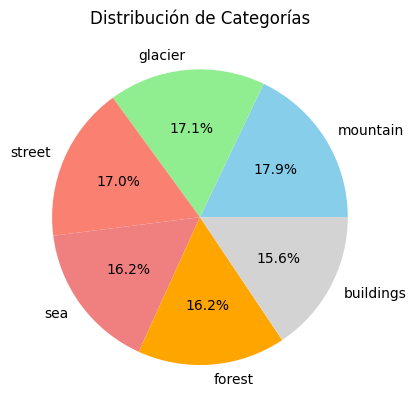

In [6]:
# Porcentaje de cada categoría
category_percent = df['category'].value_counts(normalize=True) * 100
category_percent.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightgreen', 'salmon', 'lightcoral', 'orange', 'lightgrey'])
plt.title('Distribución de Categorías')
plt.ylabel('')
plt.show()

La distribución de las categorías en el dataset muestra un equilibrio relativamente bueno entre las diferentes clases. Cada categoría presenta una proporción similar de imágenes, lo que sugiere que el modelo de aprendizaje automático tendrá suficiente información de cada clase para aprender a diferenciarlas.

Este balance en la distribución de clases es beneficioso, ya que ayuda a prevenir problemas de sobreajuste en el modelo y permite una mejor generalización. Sin embargo, se debe monitorear el rendimiento del modelo para asegurarse de que todas las categorías sean representadas adecuadamente durante el entrenamiento.

# 2. Modelado
### Preparación de datos

In [5]:
# Configura generador para entrenamiento con aumentación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # División de validación dentro del generador
)

# Generador para el conjunto de validación (sin aumentación)
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Directorio de las imágenes
img_folder = 'C:/Users/Joaco/Documents/ucse/dataset/train'

# Cargar las imágenes en los generadores
train_generator = train_datagen.flow_from_directory(
    img_folder,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Subconjunto de entrenamiento
)

validation_generator = validation_datagen.flow_from_directory(
    img_folder,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Subconjunto de validación
)


Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [6]:
# Visualización de la distribución del conjunto de entrenamiento
train_counts = pd.Series(train_generator.classes).value_counts()

# Visualización de la distribución del conjunto de validación
val_counts = pd.Series(validation_generator.classes).value_counts()

print("Distribución en el conjunto de entrenamiento:")
print(train_counts)

print("\nDistribución en el conjunto de validación:")
print(val_counts)


Distribución en el conjunto de entrenamiento:
3    2010
2    1924
5    1906
4    1820
1    1817
0    1753
Name: count, dtype: int64

Distribución en el conjunto de validación:
3    502
2    480
5    476
1    454
4    454
0    438
Name: count, dtype: int64


In [8]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')  # 6 categorías de salida
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10
)


Epoch 1/10
350/350 [==============================] - 158s 450ms/step - loss: 1.1652 - accuracy: 0.5385 - val_loss: 0.9667 - val_accuracy: 0.6336
Epoch 2/10
350/350 [==============================] - 156s 445ms/step - loss: 0.9442 - accuracy: 0.6388 - val_loss: 0.8832 - val_accuracy: 0.6649
Epoch 3/10
350/350 [==============================] - 161s 461ms/step - loss: 0.8503 - accuracy: 0.6774 - val_loss: 0.7533 - val_accuracy: 0.7259
Epoch 4/10
350/350 [==============================] - 158s 451ms/step - loss: 0.7762 - accuracy: 0.7128 - val_loss: 0.6395 - val_accuracy: 0.7741
Epoch 5/10
350/350 [==============================] - 159s 454ms/step - loss: 0.7350 - accuracy: 0.7283 - val_loss: 0.5397 - val_accuracy: 0.8139
Epoch 6/10
350/350 [==============================] - 162s 462ms/step - loss: 0.6848 - accuracy: 0.7554 - val_loss: 0.5488 - val_accuracy: 0.8053
Epoch 7/10
350/350 [==============================] - 162s 463ms/step - loss: 0.6571 - accuracy: 0.7593 - val_loss: 0.5018 -

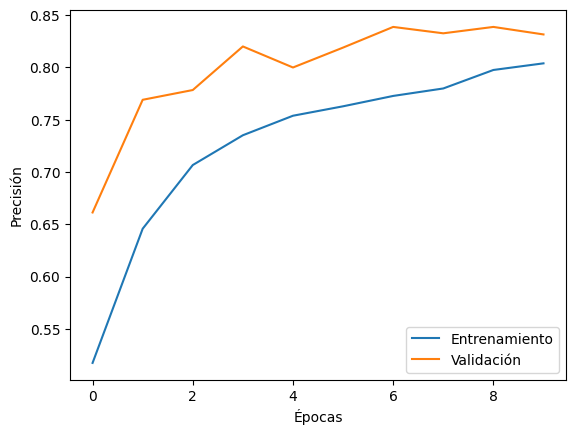

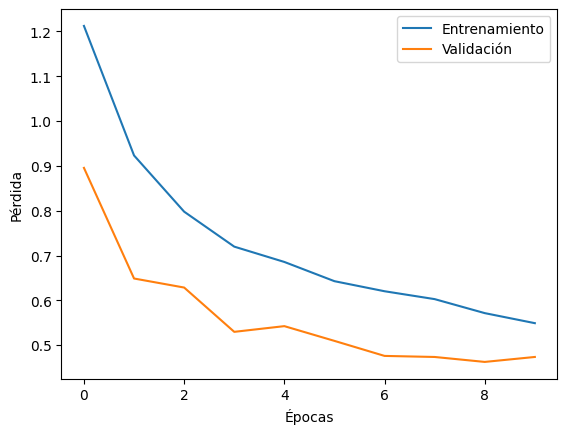

In [11]:
# Graficar precisión
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Graficar pérdida
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [15]:
# Definir la forma de entrada
input_shape = (150, 150, 3)

# Construir el modelo MLP
modelMLP = Sequential([
    Input(input_shape),
    Flatten(),
    Dense(500, activation='relu'),
    Dropout(0.25),
    Dense(len(categories), activation='softmax'),  # 'categories' debe ser la lista de tus categorías
])

# Compilar el modelo
modelMLP.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [16]:
# Entrenar el modelo
history = modelMLP.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,  # Puedes ajustar el número de épocas según sea necesario
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator)
)


Epoch 1/10
351/351 [==============================] - 73s 208ms/step - loss: 2.4168 - accuracy: 0.1708 - val_loss: 1.8342 - val_accuracy: 0.1619
Epoch 2/10
351/351 [==============================] - 69s 196ms/step - loss: 1.9689 - accuracy: 0.1701 - val_loss: 1.8064 - val_accuracy: 0.1790
Epoch 3/10
351/351 [==============================] - 68s 195ms/step - loss: 1.9378 - accuracy: 0.1680 - val_loss: 1.7828 - val_accuracy: 0.1562
Epoch 4/10
351/351 [==============================] - 68s 194ms/step - loss: 1.8956 - accuracy: 0.1706 - val_loss: 1.8098 - val_accuracy: 0.2004
Epoch 5/10
351/351 [==============================] - 68s 194ms/step - loss: 1.8843 - accuracy: 0.1741 - val_loss: 1.8243 - val_accuracy: 0.1708
Epoch 6/10
351/351 [==============================] - 69s 196ms/step - loss: 1.8690 - accuracy: 0.1737 - val_loss: 1.8197 - val_accuracy: 0.1616
Epoch 7/10
351/351 [==============================] - 68s 194ms/step - loss: 1.8408 - accuracy: 0.1752 - val_loss: 1.8013 - val_ac

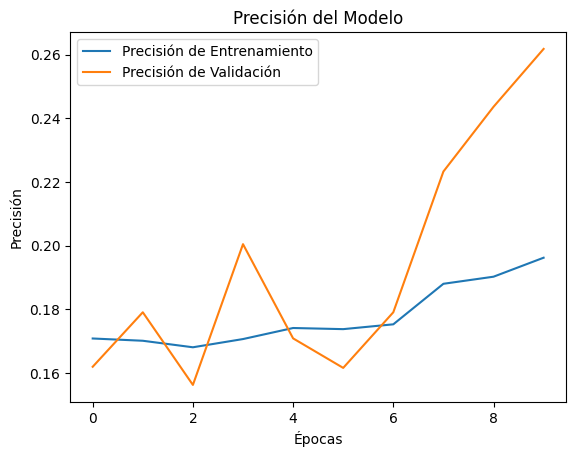

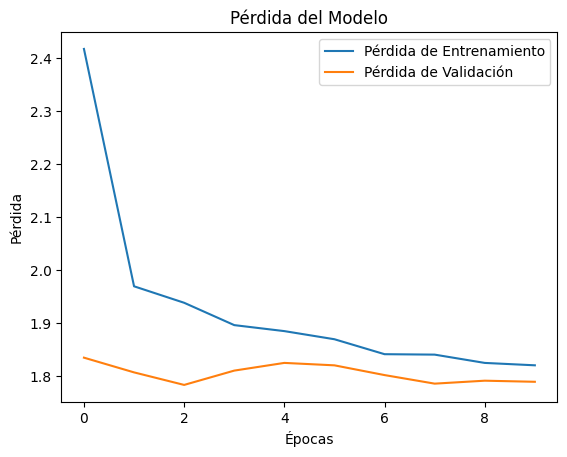

In [17]:
# Graficar la precisión
plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
plt.title('Precisión del Modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Graficar la pérdida
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida del Modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [25]:
modelConvolucional = Sequential([
    Input(input_shape),
    
    Convolution2D(filters=10, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.25),
    
    Convolution2D(filters=10, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.5),
    
    MaxPooling2D(pool_size=(4, 4)),
    
    Flatten(),
    
    Dense(100, activation='tanh'),
    Dropout(0.25),
    
    Dense(len(categories), activation='softmax'),
])

# Compilar el modelo
modelConvolucional.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
# Entrenamiento del modelo
history = modelConvolucional.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=10
)

Epoch 1/10
351/351 [==============================] - 132s 376ms/step - loss: 1.8127 - accuracy: 0.3745 - val_loss: 1.0335 - val_accuracy: 0.6098
Epoch 2/10
351/351 [==============================] - 144s 409ms/step - loss: 1.0564 - accuracy: 0.5932 - val_loss: 0.9888 - val_accuracy: 0.6066
Epoch 3/10
351/351 [==============================] - 131s 373ms/step - loss: 0.9522 - accuracy: 0.6362 - val_loss: 0.9552 - val_accuracy: 0.6227
Epoch 4/10
351/351 [==============================] - 132s 376ms/step - loss: 0.9004 - accuracy: 0.6547 - val_loss: 1.0089 - val_accuracy: 0.6277
Epoch 5/10
351/351 [==============================] - 131s 372ms/step - loss: 0.8486 - accuracy: 0.6791 - val_loss: 0.8042 - val_accuracy: 0.7011
Epoch 6/10
351/351 [==============================] - 131s 372ms/step - loss: 0.8265 - accuracy: 0.6850 - val_loss: 0.7357 - val_accuracy: 0.7286
Epoch 7/10
351/351 [==============================] - 132s 376ms/step - loss: 0.8014 - accuracy: 0.6931 - val_loss: 0.8011 -

In [27]:
# Evaluar el modelo en el conjunto de validación
val_loss, val_accuracy = modelConvolucional.evaluate(validation_generator)
print(f'Pérdida de validación: {val_loss}, Precisión de validación: {val_accuracy}')


88/88 [==============================] - 3s 34ms/step - loss: 0.7974 - accuracy: 0.7108
Pérdida de validación: 0.7973708510398865, Precisión de validación: 0.710770308971405


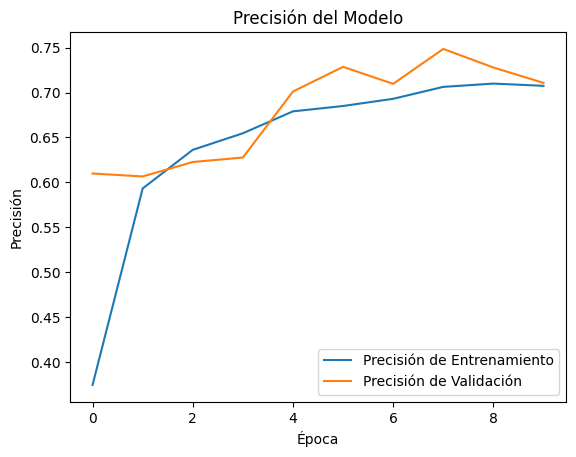

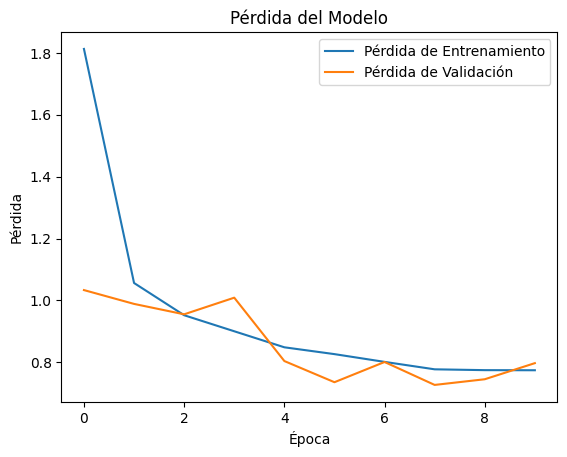

In [28]:
# Graficar la precisión y la pérdida
plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend()
plt.show()


In [16]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
CATEGORIA2 = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
SIZE = 150

def predict_images_from_directory(directory):
    results = [] 
    images = [] 

    for image_name in os.listdir(directory):
        image_path = os.path.join(directory, image_name)

        if image_name.endswith(".jpg"):
            image_array = img_to_array(load_img(image_path, target_size=(SIZE, SIZE)))
            images.append(image_array)

    inputs = np.array(images) / 255.0  

    predictions = model.predict(inputs)

    for i, image_name in enumerate(os.listdir(directory)):
        if image_name.endswith(".jpg"):
            predicted_class = CATEGORIA2[np.argmax(predictions[i])]
            results.append([image_name, predicted_class])
    
    df = pd.DataFrame(results, columns=["ID", "Label"])
    df.to_csv("prediccionesLeakyRelu2.csv", index=False)
    print("Predicciones guardadas en 'prediccionesLeakyRelu2.csv'")

predict_images_from_directory(r'C:\Users\Joaco\Documents\ucse\dataset\test')

94/94 [==============================] - 8s 79ms/step
Predicciones guardadas en 'prediccionesLeakyRelu2.csv'
